In [1]:
!pip install scikit-multilearn
!pip install python-louvain
!pip install gensim

In [2]:
import json
import pandas as pd
import time
import re
from collections import Counter
import os.path
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report, f1_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from sklearn.neural_network import MLPClassifier
from skmultilearn.adapt import MLTSVM, MLkNN, MLARAM
from sklearn.linear_model import LogisticRegression
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import MajorityVotingClassifier, LabelSpacePartitioningClassifier, RakelD
from sklearn.base import BaseEstimator, MetaEstimatorMixin
from gensim.sklearn_api import D2VTransformer
from tokenizador import Tokenizador
from sklearn.utils import shuffle
import numpy as np

In [3]:
# Tokenizador auxiliar:
class Tokenizador(BaseEstimator, MetaEstimatorMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ## Idêntico ao do scikit-learn
        ## https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/feature_extraction/text.py#L261-L266
        token_pattern = re.compile(r"(?u)\b\w\w+\b")
        parser = lambda doc: token_pattern.findall(doc)
        return [parser(x) for x in X]

### Funções utilitárias e testes realizados

In [4]:
def read_json(filename):
    with open(filename) as f:
        return json.load(f)

def dump_results(filename, results):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)

def run(normas, models, clfs, n_jobs=1):
    # Corpus e labels:
    corpus = [norma['TextoPreProcessado'] for norma in normas]
    labels = [norma['AssuntoGeral'] for norma in normas]

    # Obtém X e y:
    X = corpus
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)

    # Faz shuffle:
    X, y = shuffle(X, y, random_state=42)

    for model in models:
        for clf in clfs:
            fileName = f'{model[-1][0]}_{clf["clf"][0]}.csv'
            if os.path.isfile(fileName):
                print(f'{fileName} já existe! Ignorando!')
                continue
                
            start = time.time()
            pipeline = Pipeline([*model, clf['clf']])

            gs = GridSearchCV(pipeline, clf['params'], scoring='f1_micro', return_train_score=True, cv=IterativeStratification(n_splits=2, order=1), n_jobs=n_jobs, verbose=10)
            gs.fit(X, y)

            print('tempo gasto: ',round(time.time()-start,0),'segundos')
            print('melhores parâmetros:', gs.best_params_, 'melhor score: ', gs.best_score_)

            dump_results(fileName, gs.cv_results_)

In [5]:
def run_test1(normas):
    models = [
        [('cv', CountVectorizer(min_df=20, max_df=0.5))],
        [('tfidf', TfidfVectorizer(min_df=20, max_df=0.5))],
        [('tokenize', Tokenizador()), ('d2v', D2VTransformer(dm=0, min_count=100, size=200, workers=6))]
    ]

    clfs = [
        {
            'clf': ('dt', DecisionTreeClassifier()),
            'params': {
                'dt__min_samples_split': [0.005, 0.010, 2],
                'dt__max_depth': [16, 32, None]
            }
        },
        {
            'clf': ('rf', RandomForestClassifier()),
            'params': {
                'rf__n_estimators': [100, 110, 120],
                'rf__min_samples_split': [0.005, 0.010, 2],
                'rf__min_samples_leaf': [5, 3, 1]
            }
        },
        {
            'clf': ('mlknn', MLkNN()), 
            'params': {
                'mlknn__k': [6, 8, 10, 12], 
                'mlknn__s': [0.5, 1.0, 1.5, 2.0]
            }
        },
        {
            'clf': ('mlp', MLPClassifier()), 
            'params': {
                'mlp__hidden_layer_sizes': [(150), (100, 100), (50, 50, 50)],
                'mlp__activation': ['tanh', 'relu'],
                'mlp__solver': ['sgd', 'adam']
            }
        }
    ]
    run(normas, models, clfs)

In [6]:
def run_test2(normas, n_jobs=1):
    models = [
        [('tfidf', TfidfVectorizer(min_df=20, max_df=0.5))]
    ]

    clfs = [
        {
            'clf': ('mv_mlp', MajorityVotingClassifier(classifier=MLPClassifier())), 
            'params': {
                'mv_mlp__classifier__hidden_layer_sizes': [(150), (100, 100), (50, 50, 50)],
                'mv_mlp__classifier__activation': ['tanh', 'relu'],
                'mv_mlp__clusterer' : [
                    NetworkXLabelGraphClusterer(LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False), 'louvain'),
                    NetworkXLabelGraphClusterer(LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False), 'lpa')
                ]
            }
        }
    ]
    run(normas, models, clfs, n_jobs)

In [7]:
def run_test3(normas, n_jobs=1):
    # Corpus e labels:
    corpus = [norma['TextoPreProcessado'] for norma in normas]
    labels = [norma['AssuntoGeral'] for norma in normas]

    # Obtém X e y:
    X = corpus
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)

    # Faz shuffle:
    X, y = shuffle(X, y, random_state=42)

    # Vectorizer
    X = TfidfVectorizer(min_df=20, max_df=0.5).fit_transform(X).toarray()

    def create_model():
        model = Sequential()
        model.add(Input(X.shape[1]))
        model.add(Dense(150, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(y.shape[1], activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        return model

    # Faz cross-validação:
    results = cross_validate(KerasClassifier(build_fn=create_model, epochs=10, batch_size=200, verbose=1), X=X, y=y, return_train_score=True, cv=IterativeStratification(n_splits=2, order=1), n_jobs=n_jobs, verbose=10)
    print(results)

### Exemplo de uso do iterative_train_test_split

In [8]:
# Leitura
normas = read_json("normas_80assuntos_processadas.json")
corpus = [norma['TextoPreProcessado'] for norma in normas]
labels = [norma['AssuntoGeral'] for norma in normas]
X = corpus
X = TfidfVectorizer(min_df=20, max_df=0.5).fit_transform(X).toarray()
y = MultiLabelBinarizer().fit_transform(labels)

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.5)

# Combinações de rótulos no teste e treino
df = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row)
}).T.fillna(0.0).transpose()

display(df)

,train,test
"(0,)",178,177
"(57,)",866,865
"(16,)",86,87
"(53,)",102,102
"(63,)",161,161
...,...,...
"(33,)",29,29
"(74,)",26,25
"(67,)",13,14
"(69,)",34,33


<AxesSubplot:>

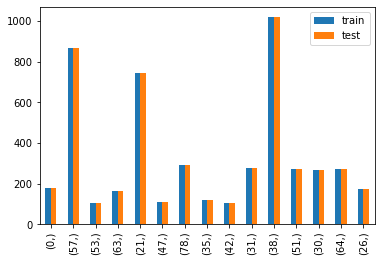

In [9]:
df[df['train']>100].plot(kind='bar')

### Exemplo de uso comum do melhor algoritmo

In [10]:
normas = read_json("normas_80assuntos_processadas.json")

In [11]:
# Corpus e labels:
corpus = [norma['TextoPreProcessado'] for norma in normas]
labels = [norma['AssuntoGeral'] for norma in normas]

In [12]:
# Obtém X e y:
X = corpus
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

In [13]:
# Vectorizer
X = TfidfVectorizer(min_df=20, max_df=0.5).fit_transform(X).toarray()
print(X.shape)

(9963, 8989)


In [14]:
# TrainTestSplit:
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.5)

In [15]:
# Classifcador:
clf = MLPClassifier(hidden_layer_sizes=(150), activation='relu')
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=150)

In [16]:
# Prevê
y_pred = clf.predict(X_test)

In [21]:
df_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

In [23]:
df_report.sort_values(by=['support'], ascending=False).head(14)

,precision,recall,f1-score,support
samples avg,0.801183,0.752926,0.762970,7549.0
weighted avg,0.903611,0.695986,0.766718,7549.0
macro avg,0.821852,0.445515,0.546106,7549.0
micro avg,0.924512,0.695986,0.794135,7549.0
38,0.982932,0.960746,0.971712,1019.0
57,0.900000,0.842775,0.870448,865.0
21,0.990251,0.956931,0.973306,743.0
78,0.995536,0.771626,0.869396,289.0
31,0.645161,0.437956,0.521739,274.0
64,0.962185,0.841912,0.898039,272.0


In [25]:
df_report.sort_values(by=['support'], ascending=False).tail(10)

,precision,recall,f1-score,support
54,1.000000,0.076923,0.142857,13.0
36,0.000000,0.000000,0.000000,13.0
72,1.000000,0.083333,0.153846,12.0
23,0.833333,0.416667,0.555556,12.0
45,1.000000,0.416667,0.588235,12.0
44,1.000000,0.500000,0.666667,12.0
3,1.000000,0.363636,0.533333,11.0
39,1.000000,0.090909,0.166667,11.0
61,1.000000,0.272727,0.428571,11.0
14,0.000000,0.000000,0.000000,10.0


In [26]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2  in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #sns.heatmap(cf_matrix, annot=labels, fmt=‘’, cmap='Blues')
    # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

    heatmap = sns.heatmap(confusion_matrix, annot=labels, fmt='', cbar=False, ax=axes, cmap='Blues')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('Previsto')
    axes.set_ylabel('Verdadeiro')
    axes.set_title(class_label, fontsize=8)

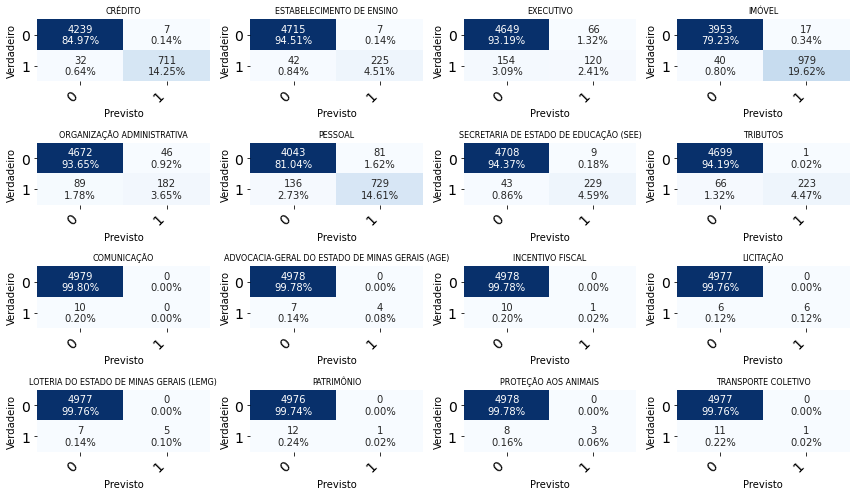

In [27]:
labels = [21, 30, 31, 38, 51, 57, 64, 78, 14, 3, 39, 44, 45, 54, 61, 72]
vis_arr = multilabel_confusion_matrix(y_test, y_pred, labels=labels)
fig, ax = plt.subplots(4, 4, figsize=(12, 7))

for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, mlb.classes_[labels]):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()  